In [2]:
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

In [3]:
dato = pd.read_csv('file_name.csv')
dato.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
labels = {0: 'Enojo', 1: 'Disgusto', 2: 'Miedo', 3: 'Felicidad', 4: 'Tristeza', 5: 'Sorpresa', 6: 'Neutral'}

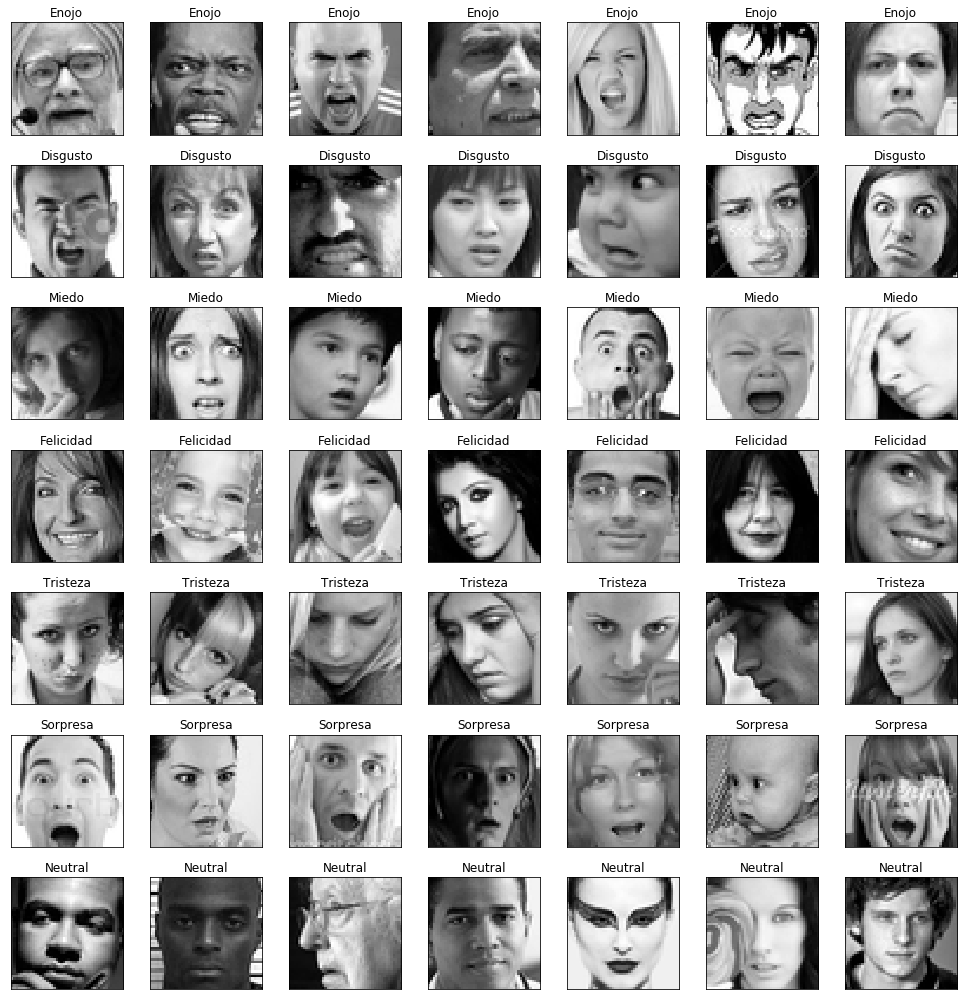

In [5]:
plt.figure(1, (14, 14))
z = 1
for i in sorted(dato.emotion.unique()):
    for j in range(7):
        X = dato[dato.emotion == i].pixels.iloc[z]
        X = np.array(X.split(' ')).reshape(48,48).astype('float32')
        plt.subplot(7,7,z)
        plt.imshow(X, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title(labels[i])
        plt.tight_layout()
        z += 1
plt.show()

In [6]:
matriz = dato.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48,48,1).astype('float32'))
matriz = np.stack(matriz, axis = 0)

In [7]:
le = LabelEncoder()
img_labels = le.fit_transform(dato.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [8]:
x_train, x_valid, y_train, y_valid = train_test_split(matriz, img_labels, shuffle=True, stratify=img_labels, test_size=0.1, random_state=42)

In [9]:
del dato
del matriz
del img_labels

In [10]:
ancho = x_train.shape[1]
alto = x_train.shape[2]
profundo = x_train.shape[3]
numero_clases = y_train.shape[1]
x_train = x_train / 255.
x_valid = x_valid / 255.

In [57]:
def red(optim):
    red = Sequential(name='RN')
    red.add(Conv2D(filters=64, kernel_size=(5,5), input_shape=(ancho, alto, profundo), activation='elu', padding='same', kernel_initializer='he_normal', name='conv2d_1'))
    red.add(BatchNormalization(name='batchnorm_1'))
    red.add(Flatten(name='flatten'))
    red.add(Dense(128, activation='elu', kernel_initializer='he_normal', name='dense_1'))
    red.add(BatchNormalization(name='batchnorm_9'))
    red.add(Dropout(0.6, name='dropout_6'))
    red.add(Dense(numero_clases, activation='softmax', name='out_layer'))
    
    red.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
    red.summary()
    
    return red

In [58]:
paro_t = EarlyStopping(monitor='val_accuracy', min_delta=0.00005, patience=11, verbose=1, restore_best_weights=True,)

lr= ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=7, min_lr=1e-7, verbose=1,)
llamado = [paro_t, lr,]

In [59]:
entrenamiento_datos = ImageDataGenerator(rotation_range=15, width_shift_range=0.15, height_shift_range=0.15, shear_range=0.15, zoom_range=0.15, horizontal_flip=True,)
entrenamiento_datos.fit(x_train)

In [63]:
optimizador = [optimizers.Nadam(learning_rate=0.001, beta_1= 0.9, beta_2=0.999, epsilon= 1e-07, name='Nadam'),optimizers.Adam(0.001),]
modelo = red(optimizador[1])
neu = modelo.fit_generator(entrenamiento_datos.flow(x_train, y_train, batch_size = 10), validation_data = (x_valid, y_valid), steps_per_epoch = len(x_train)/ 40, epochs = 200, callbacks = llamado)

Model: "RN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
flatten (Flatten)            (None, 147456)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               18874496  
_________________________________________________________________
batchnorm_9 (BatchNormalizat (None, 128)               512       
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
out_layer (Dense)            (None, 7)                 903      